<a href="https://colab.research.google.com/github/wiv33/A-Learning-python/blob/master/machine-learning/_000_hello_machine/_001_books/_006_tf2_ml_nlp/_012_aclimdb_v1_%ED%83%90%EC%83%89%EC%A0%81_%EB%8D%B0%EC%9D%B4%ED%84%B0_%EB%B6%84%EC%84%9D/_000_kaggle_movie_review/_002_kaggle_movie_review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 텐서플로 2와 머신러닝으로 시작하는 자연어 처리

# Kaggle 대회 데이터 다운로드

> 인증 토큰이 담긴 json 파일을 찾을 수 없다

In [ ]:
# !kaggle competitions download -c word2vec-nlp-tutorial

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


## 선행

* kaggle Account에서 token 생성
* google drive에 추가
* 파일을 `/root/.kaggle`로 이동

In [90]:
!mkdir .kaggle
!mv .kaggle /root/

mv: cannot move '.kaggle' to '/root/.kaggle': Directory not empty


In [91]:
!cp '/content/drive/My Drive/Colab Notebooks/auth/kaggle/kaggle.json' /root/.kaggle/

In [92]:
# !cat /root/.kaggle/kaggle.json

In [93]:
!chmod 600 /root/.kaggle/kaggle.json

## 버전 미스 매칭 확인

In [94]:
# !kaggle competitions download -c word2vec-nlp-tutorial

In [95]:
# !pip3 install --upgrade --force-reinstall --no-deps kaggle

## 최신 버전 후 403 error

In [96]:
# !kaggle competitions download -c word2vec-nlp-tutorial

# 기존 버전 삭제 후 1.5.6 버전으로 다운로드

In [97]:
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6
!kaggle -v

Found existing installation: kaggle 1.5.6
Uninstalling kaggle-1.5.6:
  Successfully uninstalled kaggle-1.5.6
Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (20.2.4)
Processing /root/.cache/pip/wheels/01/3e/ff/77407ebac3ef71a79b9166a8382aecf88415a0bcbe3c095a01/kaggle-1.5.6-py3-none-any.whl
Kaggle API 1.5.6


# content/ zip 파일 생성 확인

    다운로드 위치 /content/
    이후 drive로 이동하여 관리

In [98]:
!kaggle competitions download -c word2vec-nlp-tutorial

 64% 33.0M/51.7M [00:02<00:02, 6.97MB/s]
100% 51.7M/51.7M [00:02<00:00, 24.6MB/s]


# 다운로드 파일 압축 해제

In [99]:
!unzip /content/*.zip

Archive:  /content/word2vec-nlp-tutorial.zip
  inflating: labeledTrainData.tsv.zip  
  inflating: sampleSubmission.csv    
  inflating: testData.tsv.zip        
  inflating: unlabeledTrainData.tsv.zip  


# 해제 후 data 디렉터리로 이동

In [100]:
!mv /content/*.zip /content/*.csv '/content/drive/My Drive/Colab Notebooks/data/kaggle/movie_review/'

# python 코드 시작

In [101]:
import zipfile

DATA_IN_PATH = '/content/drive/My Drive/Colab Notebooks/data/kaggle/movie_review/'

file_list = ['labeledTrainData.tsv.zip', 'unlabeledTrainData.tsv.zip', 'testData.tsv.zip']

In [102]:
for f in file_list:
  zipRef = zipfile.ZipFile(DATA_IN_PATH + f, 'r')
  zipRef.extractall(DATA_IN_PATH)
  zipRef.close()

In [103]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

# %matplotlib inline  # 그래프 바로 그리기

# 데이터 프레임으로 만들기

In [104]:
train_data = pd.read_csv("{}labeledTrainData.tsv".format(DATA_IN_PATH),
                         header=0,
                         delimiter='\t', 
                         quoting=3)

In [105]:
train_data.head()

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


# 데이터 분석 순서

1. 데이터 크기
2. 데이터의 개수
3. 각 리뷰의 문자 길이 분포
4. 많이 사용된 단어
5. 긍정, 부정 데이터의 분포
6. 각 리뷰의 단어 개수 분포
7. 특수문자 및 대문자, 소문자 비율

## 1. 데이터(파일)의 크기

In [106]:
print("파일 크기 : ")
for f in os.listdir(DATA_IN_PATH):
  if 'tsv' in f and 'zip' not in f:
    # print(f.ljust(30))
    print(f.ljust(30) + str(round(os.path.getsize(DATA_IN_PATH + f) / 1000000, 2)) + "MB")

파일 크기 : 
labeledTrainData.tsv          33.56MB
unlabeledTrainData.tsv        67.28MB
testData.tsv                  32.72MB


In [107]:
"전체 학습 데이터 개수: {}".format(len(train_data))

'전체 학습 데이터 개수: 25000'

In [108]:
train_length = train_data['review'].apply(len)
train_length.head()

0    2304
1     948
2    2451
3    2247
4    2233
Name: review, dtype: int64

## 주요 설정

### 그래프 이미지 크기 설정

* figsize: (가로, 세로) tuple

In [109]:
plt.figure(figsize=(12, 5))

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

### 히스토그램

* bins: 히스토그램 값 버킷 범위
* range: x축 값의 범위
* alpha: 그래프 색상 투명도
* color: 그래프 색상
* label: 그래프 라벨


    ValueError: 'square' is not a valid value for scale; supported values are 'linear', 'log', 'symlog', 'logit', 'function', 'functionlog'


* yscale 첫 번째 인자의 유효 값
  - 'linear' 
  - 'log'
  - 'symlog'
  - 'logit'
  - 'function'
  - 'functionlog'
    
```python
plt.yscale()
```

### 결과 내용

    0 ~ 6000: 대부분의 데이터가 밀집한 상태
    10000 이상: 이상치로 간주



Text(0, 0.5, 'Number of review')

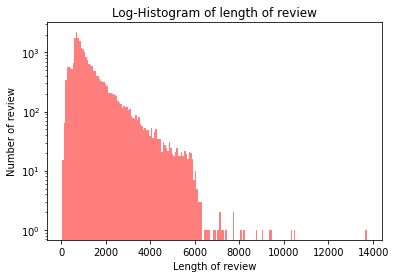

In [110]:
plt.hist(train_length, 
         bins=200, 
         alpha=.5,
         color='r',
         label='word')

# 로그의 크기를 가지도록 설정
plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of length of review')
plt.xlabel('Length of review')
plt.ylabel('Number of review')

## 통곗값 확인

- 리뷰 길이 최댓값

In [111]:
print('리뷰 길이 최댓값: {}'.format(np.max(train_length)))
print('리뷰 길이 최솟값: {}'.format(np.min(train_length)))
print('리뷰 길이 평균값: {:.2f}'.format(np.mean(train_length)))
print('리뷰 길이 표준편차: {:.2f}'.format(np.std(train_length)))
print('리뷰 길이 중간값: {}'.format(np.max(train_length)))

리뷰 길이 최댓값: 13710
리뷰 길이 최솟값: 54
리뷰 길이 평균값: 1329.71
리뷰 길이 표준편차: 1005.22
리뷰 길이 중간값: 13710


    백분위 표시
    -> 특정집단의 점수분포상에서 한 개인의 상대적 위치를 알수있는 유도점수
    25는 25% 위치에 해당한 값
    75는 75% 위치의 값
    100% 값은 리뷰 길이 최댓값과 동일한 값

- 사분위에 대한 경우는 0 ~ 100 스케일로 돼 있음

In [112]:
print('리뷰 길이 제1사분위: {}'.format(np.percentile(train_length, 25)))
print('리뷰 길이 제3사분위: {}'.format(np.percentile(train_length, 75)))
print('리뷰 길이 제4사분위: {}'.format(np.percentile(train_length, 100)))

리뷰 길이 제1사분위: 705.0
리뷰 길이 제3사분위: 1619.0
리뷰 길이 제4사분위: 13710.0


## 박스 plot

* 첫 번째 인자: 여러 분포에 대한 데이터 리스트 입력
* labels: 입력한 데이터 라벨
* showmeans: 평균값을 `마크`

{'boxes': [<matplotlib.lines.Line2D at 0x7f56eb0cf898>],
 'caps': [<matplotlib.lines.Line2D at 0x7f56eb0402b0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f56eaf5e9b0>],
 'means': [<matplotlib.lines.Line2D at 0x7f56eb062588>],
 'medians': [<matplotlib.lines.Line2D at 0x7f56eb056c88>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f56eb0e7d30>,
  <matplotlib.lines.Line2D at 0x7f56eb035630>]}

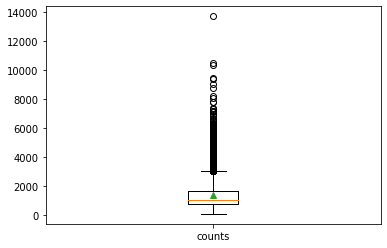

In [113]:
plt.boxplot(train_length,
            labels=['counts'],
            showmeans=True)

## 리뷰에서 많이 사용된 단어 확인

### Word Cloud

In [114]:
!pip install wordcloud

(-0.5, 799.5, 599.5, -0.5)

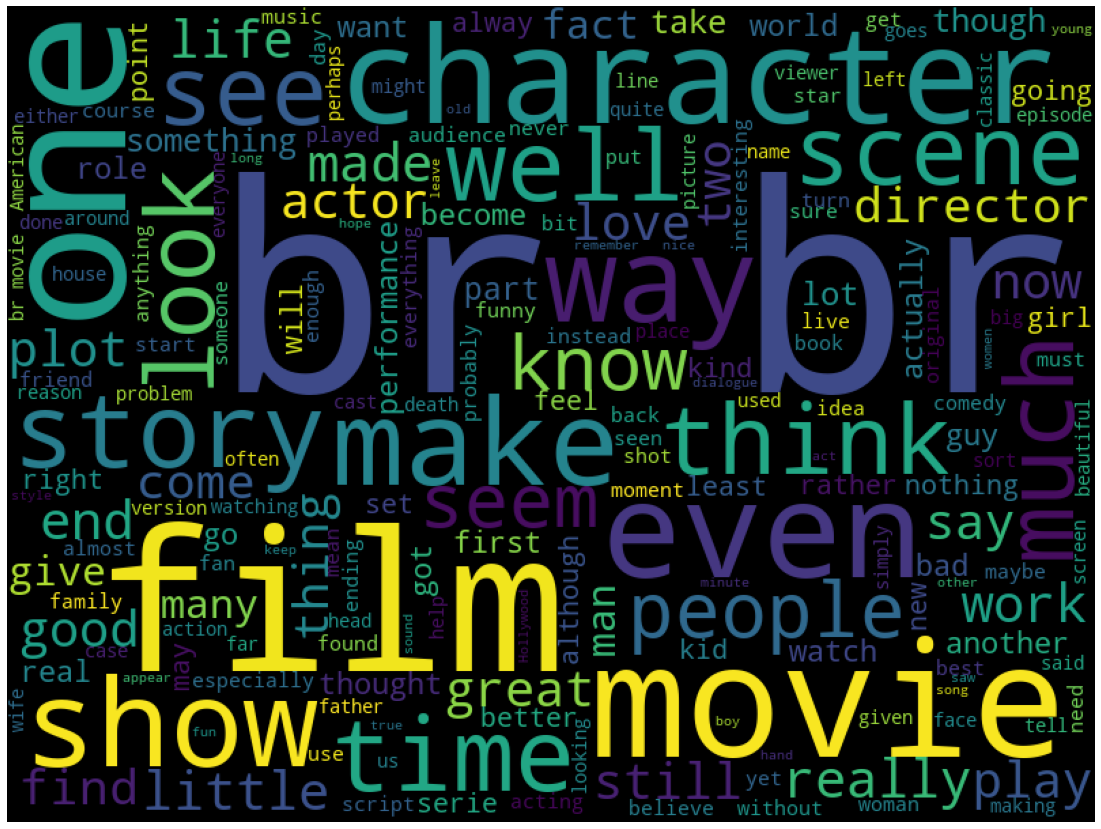

In [115]:
from wordcloud import WordCloud
cloud = WordCloud(width=800,
                  height=600).generate(" ".join(train_data['review']))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

## 긍정, 부정 데이터 분포 확인

### 씨본 (`seaborn`)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


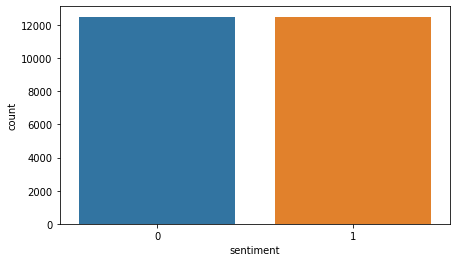

In [116]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(7, 4)
sns.countplot(train_data['sentiment'])

- sns.countplot()의 `argument` 확인하기
  * 0과 1
  * 각 숫자의 개수를 출력


In [117]:
train_data['sentiment'].head()

0    1
1    1
2    0
3    0
4    1
Name: sentiment, dtype: int64

- 각 라벨의 값 출력

In [118]:
print("긍정 리뷰 개수: {}".format(train_data['sentiment'].value_counts()[1]))
print("부정 리뷰 개수: {}".format(train_data['sentiment'].value_counts()[0]))

긍정 리뷰 개수: 12500
부정 리뷰 개수: 12500


## 단어 추출 - WordCloud

- 띄어쓰기 기준으로 하나의 단어라고 가정

In [119]:
train_word_counts = train_data['review'].apply(lambda x: len(x.split(' ')))

In [120]:
train_word_counts.head()

0    433
1    158
2    378
3    379
4    367
Name: review, dtype: int64

Text(0, 0.5, 'Number of reviews')

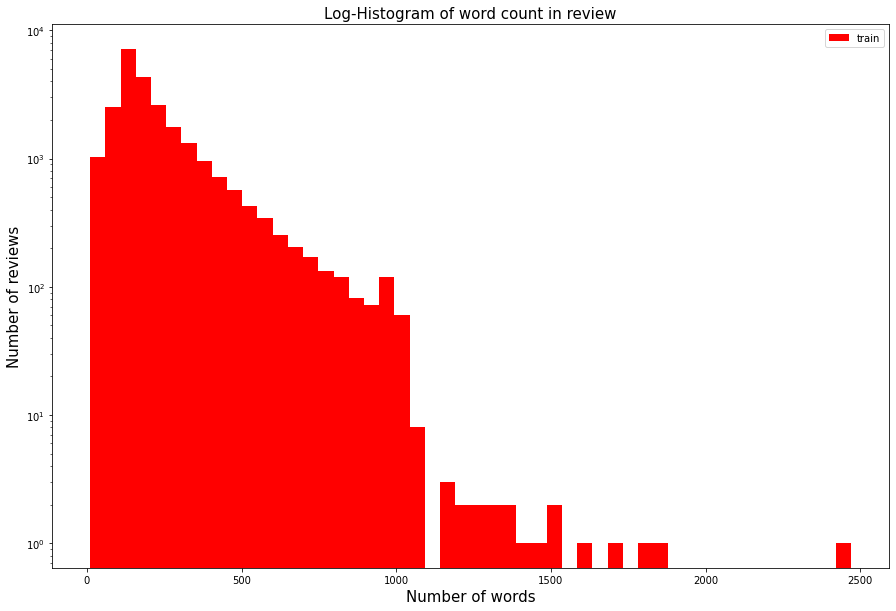

In [121]:
plt.figure(figsize=(15, 10))
plt.hist(train_word_counts,
         bins=50, 
         facecolor='r',
         label='train')
plt.title("Log-Histogram of word count in review",
          fontsize=15)
plt.yscale('log',
           nonposy='clip'
           )
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Number of reviews', fontsize=15)

## 통곗값 출력

In [122]:
print("리뷰 단어 개수 최댓값: {}".format(np.max(train_word_counts)))
print("리뷰 단어 개수 최솟값: {}".format(np.min(train_word_counts)))
print("리뷰 단어 개수 평균값: {:.2f}".format(np.mean(train_word_counts)))
print("리뷰 단어 개수 표준편차: {:.2f}".format(np.std(train_word_counts)))
print("리뷰 단어 개수 중간값: {}".format(np.median(train_word_counts)))

리뷰 단어 개수 최댓값: 2470
리뷰 단어 개수 최솟값: 10
리뷰 단어 개수 평균값: 233.79
리뷰 단어 개수 표준편차: 173.74
리뷰 단어 개수 중간값: 174.0


- 사분위 (백분위)

In [123]:
print('리뷰 단어 개수 제1사분위 : {}'.format(np.percentile(train_word_counts, 25)))
print('리뷰 단어 개수 제3사분위 : {}'.format(np.percentile(train_word_counts, 75)))

리뷰 단어 개수 제1사분위 : 127.0
리뷰 단어 개수 제3사분위 : 284.0


# 각 리뷰의 구두점, 대소문자 비율

In [124]:
def extract_by_func(func):
  return train_data['review'].apply(func)

In [125]:
def mt(x):
  return x * 100

In [126]:
qmarks = np.mean(extract_by_func(lambda x: '?' in x))  # 물음표가 구두점으로 쓰임
fullstop = np.mean(extract_by_func(lambda x: '.' in x))  # 마침표
capital_first = np.mean(extract_by_func(lambda x: x[0].isupper()))  # 첫 번째 대문자
capitals = np.mean(extract_by_func(lambda x: max([y.isupper() for y in x]))) # 대문자 개수
numbers = np.mean(extract_by_func(lambda x: max([y.isdigit() for y in x]))) # 숫자 개수

In [127]:
print('물음표가 있는 문장: {:.2f}'.format(mt(qmarks)))
print('마침표가 있는 문장: {:.2f}'.format(mt(fullstop)))
print('첫 글자가 대문자인 문장: {:.2f}'.format(mt(capital_first)))
print('대문자가 있는 문장: {:.2f}'.format(mt(capitals)))
print('숫자가 있는 문장: {:.2f}'.format(mt(numbers)))

물음표가 있는 문장: 29.55
마침표가 있는 문장: 99.69
첫 글자가 대문자인 문장: 0.00
대문자가 있는 문장: 99.59
숫자가 있는 문장: 56.66


# 위 분석을 바탕으로 `전처리 시작`

## 주요 패키지

- ## json
  
- ## bs4.BeautifulSoup
- ## nltk.corpus.stopwords
- ## tensorflow.python.keras.preprocessing.sequence.pad_sequences
- ## tensorflow.python.keras.preprocessing.txt.Tokenizer


In [128]:
!pip install nltk

In [129]:
import re
import json
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.preprocessing.text import Tokenizer

## 데이터 하나를 자세히 보기

    전처리 방향성을 결정하기 위함

In [130]:
DATA_IN_PATH
df_train_data = pd.read_csv("{}labeledTrainData.tsv".format(DATA_IN_PATH), 
                            header=0,
                            delimiter='\t')
df_train_data.iloc[0, 2]

"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally sta

## [전처리] HTML 태그, 특수문자 제거

In [131]:
review = df_train_data.iloc[0, 2]
review_text = BeautifulSoup(review, 'lxml').get_text()
review_text = re.sub('[^a-zA-Z]', ' ', review_text) # 영문자 제외, 모두 공백으로 변환

In [132]:
review_text

'With all this stuff going down at the moment with MJ i ve started listening to his music  watching the odd documentary here and there  watched The Wiz and watched Moonwalker again  Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent  Moonwalker is part biography  part feature film which i remember going to see at the cinema when it was originally released  Some of it has subtle messages about MJ s feeling towards the press and also the obvious message of drugs are bad m kay Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring  Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him The actual feature film bit when it finally starts is only on for    mi

## [전처리] 불용어 제거

    조사, 관사와 같은 어휘는
    감정 분석에 영향을 미치지 않다고 판단하여
    불용어에 포함시켰다.

- ### 제거 방법
  #### - 불용어로 정의한 사전을 이용
  #### - (현재 기준)nltk 사전을 활용
  #### - 모든 단어 소문자로 변경

영어 불용어 set 만들기

In [133]:
import nltk

In [134]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [135]:
stop_words = set(stopwords.words('english'))
len(stop_words)

179

## - [전처리] 소문자로 변경 후 불용어를 제거

In [136]:
review_text = review_text.lower()
words = review_text.split()
words = [w for w in words if not w in stop_words]

In [137]:
len(words)

219

## - [전처리] 다시 하나의 글로 합친다.

In [138]:
clean_review = ' '.join(words)
clean_review

'stuff going moment mj started listening music watching odd documentary watched wiz watched moonwalker maybe want get certain insight guy thought really cool eighties maybe make mind whether guilty innocent moonwalker part biography part feature film remember going see cinema originally released subtle messages mj feeling towards press also obvious message drugs bad kay visually impressive course michael jackson unless remotely like mj anyway going hate find boring may call mj egotist consenting making movie mj fans would say made fans true really nice actual feature film bit finally starts minutes excluding smooth criminal sequence joe pesci convincing psychopathic powerful drug lord wants mj dead bad beyond mj overheard plans nah joe pesci character ranted wanted people know supplying drugs etc dunno maybe hates mj music lots cool things like mj turning car robot whole speed demon sequence also director must patience saint came filming kiddy bad sequence usually directors hate workin

# 한 사이클의 전처리 과정을 모든 데이터에 반영할 함수 정의


In [139]:
 def ps_preprocessing(review, remove_stopwords = False):
  # 1. HTML 태그 제거
  review_text = BeautifulSoup(review, 'lxml').get_text()

  # 2. 영어가 아닌 특수문자를 공백으로 치환
  review_text = re.sub('[^a-zA-Z]', ' ', review_text)

  # 3. 대문자를 소문자로 바꾸고 공백 단위로 텍스트를 나누어 리스트로 만듦
  words = review_text.lower().split()

  # 3-1 불용어 제거하지 않을 경우 바로 반환
  if not remove_stopwords:
    return ' '.join(words)

  # 4. 불용어 제거

  # 영어 불용어 불러오기
  stops = set(stopwords.words('english'))
  # 불용어가 아닌 단어로 이뤄진 새로운 리스트 생성
  words = [w for w in words if not w in stops]

  # 5. 단어 리스트를 공백을 넣어서 하나의 글로 합친다.
  return ' '.join(words)

In [140]:
clean_train_reviews = []
for review in df_train_data['review']:
  clean_train_reviews.append(ps_preprocessing(review, remove_stopwords=True))

clean_train_reviews[0]

'stuff going moment mj started listening music watching odd documentary watched wiz watched moonwalker maybe want get certain insight guy thought really cool eighties maybe make mind whether guilty innocent moonwalker part biography part feature film remember going see cinema originally released subtle messages mj feeling towards press also obvious message drugs bad kay visually impressive course michael jackson unless remotely like mj anyway going hate find boring may call mj egotist consenting making movie mj fans would say made fans true really nice actual feature film bit finally starts minutes excluding smooth criminal sequence joe pesci convincing psychopathic powerful drug lord wants mj dead bad beyond mj overheard plans nah joe pesci character ranted wanted people know supplying drugs etc dunno maybe hates mj music lots cool things like mj turning car robot whole speed demon sequence also director must patience saint came filming kiddy bad sequence usually directors hate workin

### * 전처리한 텍스트와 긍정 부정 값 매핑

In [141]:
clean_train_df = pd.DataFrame(
    {'review': clean_train_reviews, 
     'sentiment': df_train_data['sentiment']})

clean_train_df.head()

,review,sentiment
0,stuff going moment mj started listening music ...,1
1,classic war worlds timothy hines entertaining ...,1
2,film starts manager nicholas bell giving welco...,0
3,must assumed praised film greatest filmed oper...,0
4,superbly trashy wondrously unpretentious explo...,1


## - [전처리] 전처리한 데이터에서 각 단어를 `인덱스로 벡터화`

    각 리뷰가 텍스트가 아닌 인덱스의 벡터로 구성될 것
    각 인덱스가 어떤 단어를 의미하는지 확인할 수 있어야 한다.
    
    

In [142]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_train_reviews)
text_sequences = tokenizer.texts_to_sequences(clean_train_reviews)
text_sequences[0][:5]

[404, 70, 419, 8815, 506]

### 단어 사전 확인하기

    변환된 인덱스는 단어 사전을 통해 의미 확인
    <PAD>는 padding을 의미



In [143]:
word_vocab = tokenizer.word_index
word_vocab['<PAD>'] = 0
# print(word_vocab)

In [144]:
print("전체 단어 개수: %d" % len(word_vocab))

전체 단어 개수: 74066


### 단어 사전과 전체 단어 개수는 이후 모델에서 사용되기 때문에 저장한다.

In [145]:
data_configs = {}
data_configs['vocab'] = word_vocab
data_configs['vocab_size'] = len(word_vocab) + 1

## - [전처리] 입력값의 길이를 동일하게 하는 `패딩`

    1. 특정 길이를 최대 길이로 정하고
    2. 초과하는 데이터의 뒷부분을 제거
    3. 모자란 데이터의 경우 0을 ~~앞에서~~ **뒤에서** 채운다

In [146]:
MAX_SEQUENCE_LENGTH = 174  # 문장 최대 길이
train_inputs = pad_sequences(text_sequences, maxlen=MAX_SEQUENCE_LENGTH,
                            #  padding='pre'
                             padding='post'
                             )
print('Shape of train data : ', train_inputs.shape )

Shape of train data :  (25000, 174)


## [전처리] 정답을 넘파이로 변환

    이후 전처리한 데이터를 저장할 때 넘파이 형태로 저장

In [147]:
train_labels = np.array(train_data['sentiment'])
print('Shape of label tensor: ', train_labels.shape)

Shape of label tensor:  (25000,)


# 데이터 전처리 흐름

1. 원본 텍스트
2. 인덱스 변환
3. 사이즈 패딩
4. 벡터화

# 전처리 데이터 저장

- 정제된 텍스트 데이터: **CSV**
- 벡터화한 데이터: **ndarray**
- 정답 라벨: **ndarray**
- 데이터 정보(단어 사전, 전체 단어 개수): **json**


In [148]:
REFINE = DATA_IN_PATH + "refine/"
TRAIN_INPUT_DATA = 'train_input.npy'
TRAIN_LABEL_DATA = 'train_label.npy'
TRAIN_CLEAN_DATA = 'train_clean.csv'
DATA_CONFIGS = 'data_configs.json'

if not os.path.exists(REFINE):
  os.makedirs(REFINE)

In [149]:
# 전처리된 데이터를 넘파이 형태로 저장
np.save(open(REFINE + TRAIN_INPUT_DATA, 'wb'), train_inputs)
np.save(open(REFINE + TRAIN_LABEL_DATA, 'wb'), train_labels)

# 정제된 텍스트를 CSV 형태로 저장
clean_train_df.to_csv(REFINE + TRAIN_CLEAN_DATA, index=False)

# 데이터 사전을 JSON 형태로 저장
json.dump(data_configs, open(REFINE + DATA_CONFIGS, 'w'), ensure_ascii=False)

# 평가(test)데이터 전처리



## 주의사항

  학습 데이터 전처리 후 __평가 데이터 전처리 시__
  학습 데이터에 적용한 토크나이저 객체를 계속 사용해야 인덱스가 같다.

---



In [150]:
test_data = pd.read_csv(DATA_IN_PATH + "testData.tsv",
                        header=0,
                        delimiter='\t',
                        quoting=3)
clean_test_reviews = []
for review in test_data['review']:
  clean_test_reviews.append(ps_preprocessing(review, remove_stopwords=True))

clean_test_df = pd.DataFrame(
    {'review': clean_test_reviews, 
     'id': test_data['id']}
    )
test_id = np.array(test_data['id'])

tokenizer.fit_on_texts(clean_test_reviews)
test_sequences = tokenizer.texts_to_sequences(clean_test_reviews)
test_inputs = pad_sequences(test_sequences, 
                            maxlen=MAX_SEQUENCE_LENGTH, 
                            padding='post')

In [151]:
def refine(s) -> str:
  return "{}{}".format(REFINE, s)

In [152]:
TEST_INPUT_DATA = 'test_input.npy'
TEST_CLEAN_DATA = 'test_clean.csv'
TEST_ID_DATA = 'test_id.npy'

np.save(open(refine(TEST_INPUT_DATA), 'wb'), test_inputs)
np.save(open(refine(TEST_ID_DATA), 'wb'), test_id)
clean_test_df.to_csv(refine(TEST_CLEAN_DATA), index=False)

# 모델링 - 로지스틱 회귀

## TF-IDF

+ 전처리 이후 데이터 불러오기

In [153]:
DATA_IN_PATH = '/content/drive/My Drive/Colab Notebooks/data/kaggle/movie_review/refine/'
TRAIN_CLEAN_DATA = 'train_clean.csv'


train_data = pd.read_csv("{}{}".format(DATA_IN_PATH,TRAIN_CLEAN_DATA), header=0, delimiter=',', quoting=3)

reviews = list(train_data['review'])
sentiments = list(train_data['sentiment'])

+ TF-IDF 벡터화

  - TfidfVectorizer args

      * ***min_df***
        
          설정 값보다 특정 토큰의 df 값이 더 적을 경우,

          벡터화 과정에서 제거

      * ***analyzer***
          
          `word`: 단어
          
          `char`: 한 문자

      * ***sublinear_tf***

          문서의 단어 빈도 수(Term frequency)에 대한 스무딩(smoothing) 여부 설정

      * ***ngram_range***

          빈도의 기본 단위 범위 설정

      * ***max_features***

          벡터의 최대 길이, 특징의 길이를 설정


      

In [154]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=.0,
                             analyzer='char', 
                             sublinear_tf=True,
                             ngram_range=(1, 3),
                             max_features=5000)

X = vectorizer.fit_transform(reviews)

+ 학습과 검증 데이터셋 분리

  - sklearn.model_selection.train_test_split

In [155]:
from sklearn.model_selection import train_test_split

RANDOM_SEED = 33
TEST_SPLIT = .2

y = np.array(sentiments)

X_train, X_eval, y_train, y_eval = train_test_split(X, y,
                                                    test_size=TEST_SPLIT, 
                                                    random_state=RANDOM_SEED)

In [156]:
X_train.shape, y_train.shape

((20000, 5000), (20000,))

+ 모델 선언 및 학습

  - Logistic Regression

In [157]:
from sklearn.linear_model import LogisticRegression

lgs = LogisticRegression(class_weight='balanced')
lgs.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

+ 검증 데이터로 성능 평가

  - accuracy: 정확도
  - precision: 정밀도
  - recall: 재현율
  - 등.

In [158]:
print('Accuracy : {:f}'.format(lgs.score(X_eval, y_eval)))

Accuracy : 0.863000


+ submit 하기 위한 데이터 확인

In [159]:
TEST_CLEAN_DATA = 'test_clean.csv'
test_data = pd.read_csv(refine(TEST_CLEAN_DATA),
                        header=0,
                        delimiter=',', 
                        quoting=3)


+ TF-IDF 값으로 벡터화

In [160]:
test_data_vecs = vectorizer.transform(test_data['review'])
test_predicted = lgs.predict(test_data_vecs)

In [161]:
test_predicted.shape

(25000,)

+ 제출할 파일 생성

In [162]:
DATA_OUT_PATH = refine('data_out/')

if not os.path.exists(DATA_OUT_PATH):
  os.makedirs(DATA_OUT_PATH)

ids = list(test_data['id'])
answer_dataset = pd.DataFrame({'id': ids, 'sentiment': test_predicted})
answer_dataset['id'] = answer_dataset['id'].apply(lambda x: x.replace('"', ''))
answer_dataset.to_csv(DATA_OUT_PATH + 'lgs_tfidf_answer.csv', index=False)

In [163]:
DATA_OUT_PATH

'/content/drive/My Drive/Colab Notebooks/data/kaggle/movie_review/refine/data_out/'

+ submit

In [164]:
!kaggle competitions submit -c word2vec-nlp-tutorial -f '/content/drive/My Drive/Colab Notebooks/data/kaggle/movie_review/refine/data_out/lgs_tfidf_answer.csv' -m 'answer by tfidf'

100% 227k/227k [00:03<00:00, 69.5kB/s]
Successfully submitted to Bag of Words Meets Bags of Popcorn

# word2vec

* 각 단어에 대해 word2vec으로 벡터화
* 단어로 표현된 리스트를 input으로 사용하기 때문에 전처리한 numpy를 사용하지 않음.
* 전처리된 텍스트 데이터를 불러온 후 각 단어들의 리스트로 나눠야 한다.


In [165]:
def refine(s) -> str:
  return "{}{}".format('/content/drive/My Drive/Colab Notebooks/data/kaggle/movie_review/refine/', s)
  
TRAIN_CLEAN_DATA = 'train_clean.csv'

train_data = pd.read_csv(refine(TRAIN_CLEAN_DATA))

reviews = list(train_data['review'])
sentiments = list(train_data['sentiment'])

sentences = [review.split() for review in reviews]

In [166]:
print(len(sentences[0]), len(sentences[1]))
pd.Series(sentences).head(2)

219 84


0    [stuff, going, moment, mj, started, listening,...
1    [classic, war, worlds, timothy, hines, enterta...
dtype: object

학습 시 필요한 하이퍼파라미터

* num_features : 각 단어에 대해 임베딩된 벡터의 차웡늘 정한다.
* min_word_count : 모델에 의미 있는 단어를 가지고 학습하기 위해 적은 빈도 수의 단어들은 학습하지 않는다.
* num_workers : 모델 학습 시 학습을 위한 프로세스 개수
* context : word2vec을 수행하기 위한 컨텍스트 윈도 크기를 지정
* down_sampling L word2vec 학습을 수행할 때 빠른 학습을 위해 정답 단어 라벨에 대한 다운샘플링 비율을 지정한다. 보통 0.001이 좋은 성능을 나타낸다고 한다.


In [167]:
num_features = 300 # 워드 벡터 특징값 수
min_word_count = 400 # 단어에 대한 최소 빈도 수
num_workers = 4 # 프로세스 개수
context = 10 # context 윈도 크기
down_sampling = 1e-3 # 다운 샘플링 비율

In [168]:
!pip install gensim

로깅 설정

In [169]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

* format과 INFO 설정 시 word2vec 학습과정에서 INFO 수준의 로그를 출력한다.

## 본격적인 학습 진행


In [170]:
from gensim.models import word2vec
print("Trainnging model ...")

Trainnging model ...


In [171]:
model = word2vec.Word2Vec(sentences,
                          workers=num_workers,
                          size=num_features,
                          min_count=min_word_count,
                          window=context,
                          sample=down_sampling)

2020-11-02 15:36:17,754 : INFO : collecting all words and their counts
2020-11-02 15:36:17,757 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-11-02 15:36:18,057 : INFO : PROGRESS: at sentence #10000, processed 1205223 words, keeping 51374 word types
2020-11-02 15:36:18,377 : INFO : PROGRESS: at sentence #20000, processed 2396605 words, keeping 67660 word types
2020-11-02 15:36:18,541 : INFO : collected 74065 word types from a corpus of 2988089 raw words and 25000 sentences
2020-11-02 15:36:18,542 : INFO : Loading a fresh vocabulary
2020-11-02 15:36:18,593 : INFO : effective_min_count=400 retains 1245 unique words (1% of original 74065, drops 72820)
2020-11-02 15:36:18,594 : INFO : effective_min_count=400 leaves 1821869 word corpus (60% of original 2988089, drops 1166220)
2020-11-02 15:36:18,603 : INFO : deleting the raw counts dictionary of 74065 items
2020-11-02 15:36:18,608 : INFO : sample=0.001 downsamples 52 most-common words
2020-11-02 15:36:18,609

## 모델 저장

> 모델의 하이퍼파라미터를 설정한 내용을 모델 이름에 담는다면 나중에 참고하기 좋다.

> 모델을 저장하면 `Word2Vec.load()`를 통해 모델을 다시 사용할 수 있다.


In [172]:
model_name = "300features_40minwords_10context" 
model.save(model_name)

2020-11-02 15:36:41,053 : INFO : saving Word2Vec object under 300features_40minwords_10context, separately None
2020-11-02 15:36:41,055 : INFO : not storing attribute vectors_norm
2020-11-02 15:36:41,057 : INFO : not storing attribute cum_table
2020-11-02 15:36:41,101 : INFO : saved 300features_40minwords_10context


## 만들어진 word2vec 모델을 활용해 선형 회귀 모델을 학습

학습하기 위한 조건

- 하나의 리뷰를 같은 형태의 입력값으로 만들어야 한다.

문장에 있는 모든 단어의 벡터값에 대해 평균을 내서 리뷰 하나당 하나의 벡터로 만드는 방법이 있다.

### 하나의 리뷰에 대해 전체 단어의 평균값을 계산하는 함수를 구현

In [173]:
def get_features(words, model, num_features):
  # 출력 벡터 초기화
  # 속도를 높히기 위해 zeros를 사용
  feature_vector = np.zeros(num_features, dtype=np.float32)

  num_words = 0

  # 어휘사전 준비
  index2word_set = set(model.wv.index2word)

  for w in words:
    # print(f'this words is : {model[w]}')
    if w in index2word_set:
      num_words += 1

      #사전에 해당하는 단어에 대해 단어 벡터를 더함
      feature_vector = np.add(feature_vector, model[w])

  #문장의 단어 수만큼 나누어 단어 벡터의 평균값을 문장 벡터로 함
  feature_vector = np.divide(feature_vector, num_words)
  return feature_vector

* words: 단어의 모음인 하나의 리뷰가 들어간다.
* model: word2vec 모델을 넣는 곳이며, 위에서 학습시킨 word2vec 모델이 들어간다.
* num_features: word2vec으로 임베딩할 때 정했던 벡터의 차원 수를 뜻한다.


In [174]:
def get_dataset(reviews, model, num_features):
  dataset = [get_features(s, model, num_features) for s in reviews]

  reviewFeatureVecs = np.stack(dataset)

  return reviewFeatureVecs

* reviews: 학습 데이터인 전체 리뷰 데이터를 입력으로 하는 인자.
* model: word2vec 모델을 입력하는 인자다. 위 함수와 같이 앞에서 학습시킨 모델을 넣는다.
* num_features: word2vec으로 임베딩할 때 정했던 벡터의 차원 수를 뜻한다.


In [175]:
test_data_vecs = get_dataset(sentences, model, num_features)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [176]:
test_data_vecs.shape

(25000, 300)

## 학습과 검증 데이터셋 분리

> 이전에 작업한 tf-idf와 동일

In [177]:
from sklearn.model_selection import train_test_split
import numpy as np

X = test_data_vecs
y = np.array(sentiments)

RANDOM_SEED = 42
TEST_SPLIT = .2

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=TEST_SPLIT,
                                                    random_state=RANDOM_SEED)

### 모델 선언 및 학습

> tf-idf와 동일한 로지스틱 모델을 사용.
> 
> 입력값을 어떤 특징으로 뽑았는지만 다르고 나머지는 동일하다.


In [178]:
from sklearn.linear_model import LogisticRegression

lgs = LogisticRegression(class_weight='balanced')
lgs.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

검증

In [179]:
print(f'Accuracy: {lgs.score(X_test, y_test)}')

Accuracy: 0.8546


In [180]:
predicted = lgs.predict(X_test)
from sklearn import metrics

fpr, tpr, _ = metrics.roc_curve(y_test, (lgs.predict_proba(X_test)[:, 1]))
auc = metrics.auc(fpr, tpr)

print("------------")
print("Accuracy: %f" % lgs.score(X_test, y_test))  #checking the accuracy
print("Precision: %f" % metrics.precision_score(y_test, predicted))
print("Recall: %f" % metrics.recall_score(y_test, predicted))
print("F1-Score: %f" % metrics.f1_score(y_test, predicted))
print("AUC: %f" % auc)


------------
Accuracy: 0.854600
Precision: 0.850274
Recall: 0.863438
F1-Score: 0.856805
AUC: 0.926684


In [181]:
TEST_CLEAN_DATA = 'test_clean.csv'
test_data = pd.read_csv(refine(TEST_CLEAN_DATA))

test_review = list(test_data['review'])

평가 데이터도 학습 데이터와 동일하게 단어 리스트로 만든다.

In [182]:
test_sentences = [review.split() for review in test_review]

이전에 학습시킨 모델을 사용해 각 단어들을 벡터로 만들어 리뷰에 대한 특징값을 만든다.


In [183]:
test_data_vecs = get_dataset(test_sentences, model, num_features)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [184]:
test_predicted = lgs.predict(test_data_vecs)

In [185]:
DATA_OUT_PATH = refine('data_out/')

if not os.path.exists(DATA_OUT_PATH):
  os.makedirs(DATA_OUT_PATH)

ids = list(test_data['id'])
answer_dataset = pd.DataFrame({'id': ids, 'sentiment': test_predicted})
answer_dataset['id'] = answer_dataset['id'].apply(lambda x: x.replace('"', ''))
answer_dataset.to_csv(DATA_OUT_PATH + 'lgs_word2vec_answer.csv', index=False)

submit

In [ ]:
!kaggle competitions submit -c word2vec-nlp-tutorial -f '/content/drive/My Drive/Colab Notebooks/data/kaggle/movie_review/refine/data_out/lgs_word2vec_answer.csv' -m 'answer by word2vec'

100% 227k/227k [00:03<00:00, 64.0kB/s]
Successfully submitted to Bag of Words Meets Bags of Popcorn

# Random Forest Regression

    n 개의 의사결정 트리를 만들고 각 결과들의 평균을 내서 최종 결과를 만든다.

더 좋은 결과를 만들기

 ## CounterVectorizer 벡터화

In [186]:
import pandas as pd
import numpy as np
DATA_IN_PATH = '/content/drive/My Drive/Colab Notebooks/data/kaggle/movie_review/refine/'
DATA_CLEAN_DATA = 'train_clean.csv'

train_data = pd.read_csv(f'{DATA_IN_PATH}{DATA_CLEAN_DATA}')
reviews = list(train_data['review'])
y = np.array(train_data['sentiment'])

### 텍스트 데이터를 `특징 데이터`로 만든다.

In [187]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer='word', max_features=5000)
train_data_features = vectorizer.fit_transform(reviews)

In [188]:
train_data_features.data, train_data_features.shape

(array([1, 3, 1, ..., 1, 1, 1]), (25000, 5000))

- 25000 row가 각각 5000개의 특징값을 가지는 벡터로 표현되었다.

## 학습과 검증 데이터 분리

학습 데이터의 일부를 검증 데이터로 만들어 모델의 성능을 측정한다.


In [189]:
from sklearn.model_selection import train_test_split
TEST_SIZE = .2
RANDOM_SEED = 33

train_input, test_input, train_label, test_label = train_test_split(train_data_features,
                                                                     y,
                                                                     test_size=TEST_SIZE,
                                                                     random_state=RANDOM_SEED)


In [190]:
train_input.shape, train_label.shape

((20000, 5000), (20000,))

## 모델 구현 및 학습

- 랜덤 포레스트 구현

In [191]:
from sklearn.ensemble import RandomForestClassifier

# 랜덤 포레스트 분류기에 100개의 의사결정 트리를 사용
forest = RandomForestClassifier(n_estimators=100)

#단어 묶음을 벡터화한 데이터와 정답 데이터를 가지고 학습을 시작한다.
forest.fit(train_input, train_label)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

## 검증 데이터셋으로 성능 평가

로지스틱 회귀와 비슷하다.

In [192]:
print(f'Accuracy: {forest.score(test_input, test_label)}')

Accuracy: 0.8426


In [193]:
TEST_CLEAN_DATA = 'test_clean.csv'

test_data = pd.read_csv(f'{DATA_IN_PATH}{TEST_CLEAN_DATA}')

test_review = list(test_data['review'])
ids = list(test_data['id'])

In [194]:
test_data_features = vectorizer.transform(test_review)

In [195]:
test_data_features.shape

(25000, 5000)

In [196]:
result = forest.predict(test_data_features)

output = pd.DataFrame(data={'id': ids, 'sentiment': result})
output.to_csv(f'{DATA_IN_PATH}data_out/Bag_of_Words_model.csv', index=False, quoting=3)

submit

In [ ]:
!kaggle competitions submit -c word2vec-nlp-tutorial -f '/content/drive/My Drive/Colab Notebooks/data/kaggle/movie_review/refine/data_out/Bag_of_Words_model.csv' -m 'answer by RandomForest'

100% 276k/276k [00:01<00:00, 170kB/s]
Successfully submitted to Bag of Words Meets Bags of Popcorn

# RNN

순차적인 데이터에 대한 모델링이 가능

랜덤 시드 고정

* 학습한 상황을 그대로 보존하는 것

In [205]:
import tensorflow as tf
from tensorflow.keras import layers

SEED_NUM = 333
tf.random.set_seed(SEED_NUM)

## 학습 데이터 불러오기

In [199]:
ROOT_PATH = '/content/drive/My Drive/Colab Notebooks/data/kaggle/movie_review/refine/'

DATA_IN_PATH = ROOT_PATH + 'data_in/'
DATA_OUT_PATH = ROOT_PATH + 'data_out/'
TRAIN_INPUT_DATA = ROOT_PATH + 'train_input.npy'
TRAIN_LABEL_DATA = ROOT_PATH + 'train_label.npy'
DATA_CONFIGS = ROOT_PATH + 'data_configs.json'

train_input = np.load(open(TRAIN_INPUT_DATA, 'rb'))
train_input = pad_sequences(train_input, maxlen=train_input.shape[1])
train_label = np.load(open(TRAIN_LABEL_DATA, 'rb'))
prepro_configs = json.load(open(DATA_CONFIGS, 'r'))

### 모델 하이퍼파라미터 정의

In [201]:
model_name = 'rnn_classifier_en'
BATCH_SIZE = 128
NUM_EPOCHS = 5
VALID_SPLIT = .1
MAX_LEN = train_input.shape[1]


kargs = {'model_name': model_name,
         'vocab_size': prepro_configs['vocab_size'],
         'embedding_dimension': 100,
         'dropout_rate': .2,
         'lstm_dimension': 150,
         'dense_dimension': 150,
         'output_dimension': 1
         }

### 모델 구현

In [210]:
class RNNClassifier(tf.keras.Model):
  def __init__(self, **kargs):
    super(RNNClassifier, self).__init__(name=kargs['model_name'])
    self.embedding = layers.Embedding(input_dim=kargs['vocab_size'], output_dim=kargs['embedding_dimension'])
    self.lstm_1_layer = tf.keras.layers.LSTM(kargs['lstm_dimension'], return_sequences=True)
    self.lstm_2_layer = tf.keras.layers.LSTM(kargs['lstm_dimension'])
    self.dropout = layers.Dropout(kargs['dropout_rate'])
    self.fc1 = layers.Dense(units=kargs['dense_dimension'], activation=tf.keras.activations.tanh)
    self.fc2 = layers.Dense(units=kargs['output_dimension'], activation=tf.keras.activations.sigmoid)
  
  def call(self, x):
    x = self.embedding(x)
    x = self.dropout(x)
    x = self.lstm_1_layer(x)
    x = self.lstm_2_layer(x)
    x = self.dropout(x)
    x = self.fc1(x)
    x = self.fc2(x)
    return x

### 모델 생성

In [212]:
model = RNNClassifier(**kargs)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])

### 모델 학습

In [216]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# overfittings을 막기 위한 earlystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=2)

# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no imporovment epochs (patience = 1, 1번 이상 상승이 없으면 종료)

checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
  print('{} -- Folder already exists \n'.format(checkpoint_dir))
else:
  os.makedirs(checkpoint_dir, exist_ok=True)
  print('{} -- Folder create complete \n'.format(checkpoint_dir))

cp_callback = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, 
                              save_best_only=True,
                              save_weights_only=True)
history = model.fit(train_input, train_label, 
                    batch_size=BATCH_SIZE, 
                    epochs=NUM_EPOCHS,
                    validation_split=VALID_SPLIT,
                    callbacks=[earlystop_callback, cp_callback])


/content/drive/My Drive/Colab Notebooks/data/kaggle/movie_review/refine/data_out/rnn_classifier_en -- Folder already exists 

Epoch 1/5
176/176 [==============================] - ETA: 0s - loss: 0.6930 - accuracy: 0.5081
Epoch 00001: val_accuracy improved from -inf to 0.51080, saving model to /content/drive/My Drive/Colab Notebooks/data/kaggle/movie_review/refine/data_out/rnn_classifier_en/weights.h5
176/176 [==============================] - 253s 1s/step - loss: 0.6930 - accuracy: 0.5081 - val_loss: 0.6928 - val_accuracy: 0.5108
Epoch 2/5
176/176 [==============================] - ETA: 0s - loss: 0.6902 - accuracy: 0.5158
Epoch 00002: val_accuracy improved from 0.51080 to 0.54440, saving model to /content/drive/My Drive/Colab Notebooks/data/kaggle/movie_review/refine/data_out/rnn_classifier_en/weights.h5
176/176 [==============================] - 261s 1s/step - loss: 0.6902 - accuracy: 0.5158 - val_loss: 0.6856 - val_accuracy: 0.5444
Epoch 3/5
176/176 [==============================] 

In [219]:
plot_graphs(history, 'loss')

NameError: ignored

In [ ]:
plot_graphs(history, 'accuracy')

### 데이터 제출


In [221]:
DATA_IN_PATH

'/content/drive/My Drive/Colab Notebooks/data/kaggle/movie_review/refine/data_in/'

In [224]:
ROOT = '/content/drive/My Drive/Colab Notebooks/data/kaggle/movie_review/refine/'
TEST_INPUT_DATA = 'test_input.npy'
TEST_ID_DATA = 'test_id.npy'
SAVE_FILE_NM = 'weights.h5'

test_input = np.load(open(ROOT + TEST_INPUT_DATA, 'rb'))
test_input = pad_sequences(test_input, maxlen=test_input.shape[1])

model.load_weights(os.path.join(DATA_OUT_PATH, model_name, SAVE_FILE_NM))

In [225]:
predictions = model.predict(test_input, batch_size=BATCH_SIZE)
predictions = predictions.squeeze(-1)

test_id = np.load(open(DATA_IN_PATH + TEST_ID_DATA, 'rb'), allow_pickle=True)
if not os.path.exists(DATA_OUT_PATH):
  os.makedirs(DATA_OUT_PATH)

output = pd.DataFrame(data={'id': list(test_id), 'sentiment': list(predictions)})
output.to_csv(DATA_OUT_PATH + 'movie_review_result_run.csv', index=False, quotings=3)

InvalidArgumentError: ignored

submit

In [ ]:
!kaggle competitions submit -c word2vec-nlp-tutorial -f '/content/drive/My Drive/Colab Notebooks/data/kaggle/movie_review/refine/data_out/movie_review_result_run.csv' -m 'answer by RNN'

# CNN 

주요 내용

- RNN: 단어의 입력 순서
- CNN: 문장의 위치(지역) 정보를 보존 (n-gram) 방식을 떠올릴 수 있다.


### CNN 모델 텍스트 구조


input: [배치크기, 문장길이]
word Embedding: [배치크기, 문장길이, 임베딩크기]

Dropout

Convolution: [배치크기, 컨볼루션 값, 필터크기, **커널사이즈**]

Max-polling: [배치크기, 컨볼루션 값, 필터크기]

Fully-Connected: [배치크기, 컨볼루션 값, 필터크기]

Dropout

Dense Layer: ['배치크기, 로짓 값(예측 확률 값)]

## 하이퍼파라미터 정의


In [ ]:
model_name = 'cnn_classifier_en'

BATCH_SIZE = 512
NUM_EPOCHS = 2
VALID_SPIT = .1
MAX_LEN = train_input.shape[1]

kargs = {'model_name': model_name,
         'vocab_size': prepro_configs['vocab_size'],
         'embedding_size': 128,
         'num_filters': 100,
         'dropout_rate': .5,
         'hidden_dimension': 250,
         'output_dimension': 1}